
<div style="text-align: right;">
    MA. Language Analysis and Processing<br>
    <em>In a Vector Space of La Mancha, whose Position I Do Wish to Recall:</em><br>
    <em>A comprehensive Evaluation of Word Embeddings</em><br>
    María García-Abadillo Velasco
</div>

<center><h1 style="font-size: 30px;">Training and Evaluating Word Embeddings with fasttext </h1></center>

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Training-and-Evaluating-Word-Embeddings-with-fasttext-" data-toc-modified-id="Training-and-Evaluating-Word-Embeddings-with-fasttext--1">Training and Evaluating Word Embeddings with fasttext </a></span><ul class="toc-item"><li><span><a href="#Introduction" data-toc-modified-id="Introduction-1.1">Introduction</a></span></li><li><span><a href="#fastText" data-toc-modified-id="fastText-1.2">fastText</a></span></li><li><span><a href="#Embedding-training-with-fasttext" data-toc-modified-id="Embedding-training-with-fasttext-1.3">Embedding training with fasttext</a></span><ul class="toc-item"><li><span><a href="#Hyperparameters" data-toc-modified-id="Hyperparameters-1.3.1">Hyperparameters</a></span></li></ul></li><li><span><a href="#Intrinsic-Evaluation" data-toc-modified-id="Intrinsic-Evaluation-1.4">Intrinsic Evaluation</a></span><ul class="toc-item"><li><span><a href="#Analogy-test" data-toc-modified-id="Analogy-test-1.4.1">Analogy test</a></span></li><li><span><a href="#toefl-test" data-toc-modified-id="toefl-test-1.4.2">toefl test</a></span></li><li><span><a href="#lasolana-embeddings" data-toc-modified-id="lasolana-embeddings-1.4.3">lasolana embeddings</a></span><ul class="toc-item"><li><span><a href="#Analogy-test" data-toc-modified-id="Analogy-test-1.4.3.1">Analogy test</a></span></li><li><span><a href="#toefl-test" data-toc-modified-id="toefl-test-1.4.3.2">toefl test</a></span></li></ul></li><li><span><a href="#fasttext-Spanish-embeddings" data-toc-modified-id="fasttext-Spanish-embeddings-1.4.4">fasttext Spanish embeddings</a></span><ul class="toc-item"><li><span><a href="#Analogy-test" data-toc-modified-id="Analogy-test-1.4.4.1">Analogy test</a></span></li><li><span><a href="#toefl-test" data-toc-modified-id="toefl-test-1.4.4.2">toefl test</a></span></li></ul></li><li><span><a href="#lasolana+fasttest-embeddings" data-toc-modified-id="lasolana+fasttest-embeddings-1.4.5">lasolana+fasttest embeddings</a></span><ul class="toc-item"><li><span><a href="#Analogy-test" data-toc-modified-id="Analogy-test-1.4.5.1">Analogy test</a></span></li><li><span><a href="#toefl-test" data-toc-modified-id="toefl-test-1.4.5.2">toefl test</a></span></li></ul></li></ul></li><li><span><a href="#Extrinsic-Evaluation:-Text-Classification" data-toc-modified-id="Extrinsic-Evaluation:-Text-Classification-1.5">Extrinsic Evaluation: Text Classification</a></span><ul class="toc-item"><li><span><a href="#Data-Analysis" data-toc-modified-id="Data-Analysis-1.5.1">Data Analysis</a></span></li><li><span><a href="#Preprocessing" data-toc-modified-id="Preprocessing-1.5.2">Preprocessing</a></span></li><li><span><a href="#Training-and-Results" data-toc-modified-id="Training-and-Results-1.5.3">Training and Results</a></span><ul class="toc-item"><li><span><a href="#lasolana" data-toc-modified-id="lasolana-1.5.3.1">lasolana</a></span></li><li><span><a href="#fasttest" data-toc-modified-id="fasttest-1.5.3.2">fasttest</a></span></li><li><span><a href="#lasolana+fasttest" data-toc-modified-id="lasolana+fasttest-1.5.3.3">lasolana+fasttest</a></span></li></ul></li><li><span><a href="#Final-Results" data-toc-modified-id="Final-Results-1.5.4">Final Results</a></span></li><li><span><a href="#Conclusion" data-toc-modified-id="Conclusion-1.5.5">Conclusion</a></span></li></ul></li></ul></li></ul></div>

## Introduction

This notebook presents the second part of the `lasolana-embeddings` project, where we train word embeddings using the `fasttext` library with data related to the town of La Solana. We also provide an evaluation set to assess the quality of our embeddings intrinsically and build a Random Forest classifier to evaluate the embeddings extrinsically.

A separate notebook dedicated to the preprocessing process can be found in the GitHub repository.

In [1]:
import pandas as pd
import scipy
from scipy.spatial import distance
import fasttext
import numpy as np
import textacy
from textacy import preprocessing as preproc
import spacy
from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from utils_train_eval import (
                   get_analogies,
                   compute_accuracy,
                   joint_accuracy,
                   compute_vector_distance,
                   get_acc_RandomForestClassifier,
                   plot_conf_matrix
                )

nlp = spacy.load("es_core_news_sm")


## fastText

FastText is a library developed by Facebook (now Meta) and first launched in 2015. According to the developers' website: 'FastText is an open-source, free, lightweight library that allows users to learn text representations and text classifiers'. In this notebook, we will be looking at their module for text represenation (unsupervised learning).

The fastText embeddings differ from standard Word2Vec embeddings in how they create word vectors. fastText vectors are composed of word vectors from the word itself and their n-grams (subwords). This means that character n-grams, which are also in the vocabulary, are used to create the vectors. Thus, a word's representation is the sum of the word itself, its n-grams, and a starting and ending token. The training process is identical to that of Word2Vec.

For example, the vector for the word 'racimo' would be formed by: < racimo />, <ra, rac, aci, cim, imo, mo />.

This approach may be beneficial for morphology-rich languages and can help represent out-of-vocabulary or misspelled words. We chose this library because, as explained in the preprocessing notebook, our data may have noisy sentences due to conversion problems that could not be addressed during preprocessing. **However, preliminary results showed that the standard skipgram model without subwords yielded better results than the subword model. Therefore, we will be using the standard version in this project**.


## Embedding training with fasttext

### Hyperparameters

We conducted a preliminary 'in-domain' analogy test on La Solana using various parameters to determine the optimal combination for our embeddings. Although accuracy was not evaluated. We followed the recommendations in Lai et al. for the initial parameters.

- **skipgram vs. cbow**: No test was conducted to compare both models due to time constraints. The paper's recommendation was followed: 'in case of smaller corpus, a simpler model, such as Skip-gram, can achieve bettter results'.
- **Subwords**: As mentioned above, the embeddings performed better in the first analogy test without subwords and therefore 'minn' and 'maxn' hyperparameters were set to 0 as in default modus.
- **Dimensions**: According to the paper, 'for tasks that analayzing the semantic properties of a word embeddings, larger dimensions can provide better results. (...) [A]s feature or for initialization, a dimensionalirty of 50 is sufficient'. The dimensions were set to 150 based on our observation that it performed well in the analogy test and we anticipated that it would not have a negative impact on the classification test.
- **epoch**: It was observed that using a default value of 5 epochs improved results compared to using a smaller number of epochs, but stagnated with a larger number.
- **ws**: Size of the context window. It was set to 5 as in Mikolov et al.
- **neg**: Negative Sampling. Mikolov et al. show that setting this hyperparameter to 5 'achieves a respectable accuracy' and did further experiments with neg=15 that obtained 'a considerable better performace'. We kept the default setting at 5 because there were no substantial differences in results, and the initial approach was less time-consuming.

Other options available in the `fasttext` library were set to default. The [List of Options] can be checked here (https://fasttext.cc/docs/en/options.html).

In [2]:
#model_without_subwords = fasttext.train_unsupervised('underscore.txt', "skipgram", maxn=0, dim=150, epoch=5, ws=5, neg=5, loss=softmax)

The function `save_model` stores the trained embeddings in bin or vec format.

In [3]:
#model_without_subwords.save_model("lasolana_embeddings.bin")

In [4]:
#model_without_subwords.save_model("lasolana_embeddings.vec")

The `load_model` function loads the bin file, so there is no need to train the embeddings every time the notebook is run.

In [5]:
model_without_subwords = fasttext.load_model("lasolana_embeddings.bin")

We can check our trained embeddings with the function `get_word_vector` and a word of our choice.

In [6]:
uva = model_without_subwords.get_word_vector("uva")
print(f'Embedding Dimension: {len(uva)}')
print(uva)

Embedding Dimension: 150
[-0.5273106  -0.39260942 -0.24089144  0.44986957  0.11556076  0.30784723
 -0.16992638  0.13188002  0.26897743  0.3934884  -0.14891402  0.19025896
 -0.01511345  0.13644227  0.05657289  0.14651524 -0.06362846  0.61355805
  0.14019467 -0.2838383  -0.23814662  0.10784842 -0.25331277 -0.456323
  0.2692011  -0.2708984   0.3179567   0.01972751 -0.14685082  0.13099718
 -0.41180402 -0.9037126  -0.6191731  -0.28085202 -0.40101272  0.12898223
 -0.06868472 -0.09243235  0.21697354  0.6108568   0.7044967   0.530805
  0.22137526  0.19009973  0.91498643  0.17874297 -0.08945675  0.32607272
 -0.09734905 -0.6758606   0.23029248 -0.6165424  -0.08551025  0.4861766
 -0.24308553 -0.3751549  -0.5358301  -0.04808812 -0.0590622   0.13965139
  0.26524103  0.05047992 -0.05306007  0.0266733  -0.10046843  0.17159301
  0.06350871  0.42901644  0.4398953  -0.03180495  0.40234295 -0.26072487
 -0.08994752  0.09915439 -0.40342182  0.22212008 -0.32681498 -0.06036621
 -0.15447155  0.21661547  0.258

Because word embeddings do not require labeled data (they rely on the distributional hypothesis) for their training process, they are considered unsupervised. However, this poses the question of how evaluate them. Following Lai et al, we designed a small evaluation benchmark for our purposes. It is composed of two main parts: **Intrinsic evaluation** and **extrinsic evaluation**.

## Intrinsic Evaluation


The intrinsic evaluation aims to assess the embedding's semantic properties and it was divided in two test:

### Analogy test
We were inspired by the well-known analogy test first published by Mikolov et al. entitled [Google analogy test](http://download.tensorflow.org/data/questions-words.txt). This test set consists of 19544 question pairs about 14 types of relations (9 morphological and 5 semantic). **However, our test is much more modest, consisting of 20 question pairs about two types of relations (in-domain `analogy_lasolana` or general `analogy_general`)**.

In [7]:
analogy_lasolana = [("vallehermoso", "pantano", "ruidera", "lagunas"),
                  ("airén", "blanco", "tinto", "tempranillo"),
                  ("solanero", "la_solana", "valdepeñas", "valdepeñero"),
                  ("valdepeñero", "valdepeñera", "solanera", "solanero"),
                  ("tomas_barreda", "teatro", "santa_catalina", "cooperativa"),
                  ("colegio", "sagrado_corazón", "instituto", "modesto_navarro"),
                  ("bodegas", "vino", "aceite", "almazaras"),
                  ("parroquia", "santa_catalina", "san_sebastián", "ermita"),
                  ("fútbol", "ff_la_solana", "cb_la_solana", "baloncesto"),
                  ("pp", "partdo_popular", "partido_socialista", "psoe"),
                   ]
                  

In [8]:
analogy_general = [("mejor", "bien", "mal", "peor"),
                  ("tener", "tenido", "vivido", "vivir"),
                  ("personas", "persona", "estudiante", "estudiantes"),
                  ("español", "españa", "alemán", "alemania"),
                  ("alcalde", "alcaldesa", "maestra", "maestro"),
                  ("comida", "comer", "beber", "bebida"),
                  ("españa", "madrid", "roma", "italia"),
                  ("dar", "dando", "hablando", "hablar"),
                  ("poco", "poquísimo", "muchísimo", "mucho"),
                  ("feliz", "felicidad", "tristeza", "triste"),
                ]

### toefl test
Following Lai et al., we created a set of questions that simulate the TOEFL example. In their experiment, the set contains 80 multiple-choice synonym questions with 4 candidates each. **In our case, the set is again more modest and has 21 questions, of which 10 are in-domain (`toefl_lasolana`) and 11 are general (`toefl_general`)**. 

Since the `fasttext` libray does not contain a function to find the most similar words and discard the less similar ones, we create our own function (see utils_train.py). To do this, we set all the words to be excluded to index 3 and expect the function to return this index as the less similar word if the embeddings are well trained.

In [9]:
ground_truth = [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]

In [10]:
toefl_lasolana = [
    ["fs_la_solana", "ff_la_solana", "cf_la_solana", "red"],
    ["membrilla", "manzanares", "valdepeñas", "jornada"],
    ["partido_popular", "izquierda_unida", "partido_socialista", "tomate"],
    ["sagrado_corazón", "javier_paulino", "el_humilladero", "inglés"],
    ["chirigota", "murga", "comparsa", "carpintería"],
    ["humilladero", "calvario", "moheda", "información"],
    ["majuelo", "vid", "cepas", "siempre"],
    ["capacho", "espuerta", "estera", "alquiler"],
    ["maitín", "navidad", "nochebuena", "fotografía"],
    ["los_macarras", "futuros_camareros", "no_trasnoches", "san_sebastián"],
    ["moje", "gachas", "migas", "ascensor"]
]


In [11]:
toefl_general = [
    ["rojo", "verde", "amarillo", "municipal"],
    ["perro", "gato", "caballo", "ajedrez"],
    ["alumnos", "alumnas", "estudiantes", "contenedores"],
    ["españa", "francia", "alemania", "carnaval"],
    ["especialmente", "absolutamente", "probablemente", "piel"],
    ["localidad", "municipio", "pueblo", "lápiz"],
    ["mucho", "mucha", "muchísimo", "iglesia"],
    ["fútbol", "baloncesto", "tenis", "felicidad"],
    ["vehículo", "coche", "automóvil", "toros"],
    ["trabajar", "trabajando", "trabajado", "edificio"],
    ["bien", "mal", "regular", "moda"]
]

Finally, the train setup is finished and we can start testing the three pairs of embeddings:
- **lasolana embeddings**: `model_without_subwords`, trained on our collected corpus using skipgram, 150 dimensions, whitout character n-grams, a window of size 5 and 5 negatives.
- **fasttext embeddings**: trained on Common Crawl and Wikipedia using CBOW, dimension reduced from 300 to 150, with character n-grams of length 5, a window of size 5 and 10 negatives.
- **finetuned lasolana+fasttext**

### lasolana embeddings

#### Analogy test
We created our own `get_analogies` function tailored to our data to effectively extract the most likely word to fill the gap according to the `.get_analogies()` function from `fasttext`. 

In [12]:
result_analogy_lasolana, solution_word_lasolana, result_analogy_general, solution_word_general = get_analogies(analogy_lasolana, analogy_general, model_without_subwords)

Finally, the accuracy for each subgroup (in-domain, general) and the average result was calculated

In [13]:
analogy_lasolana_accuracy = compute_accuracy(result_analogy_lasolana, solution_word_lasolana)
analogy_general_accuracy = compute_accuracy(result_analogy_general, solution_word_general)
joint_accuracy_analogy = joint_accuracy(result_analogy_lasolana, solution_word_lasolana, result_analogy_general, solution_word_general)

In [14]:
print(f'lasolana_embeddings_analogy_indomain: {analogy_lasolana_accuracy}')
print(f'lasolana_embeddings_analogy_general: {analogy_general_accuracy}')
print()
print(f'lasolana_embeddings_analogy_avg: {joint_accuracy_analogy}')

lasolana_embeddings_analogy_indomain: 90.0
lasolana_embeddings_analogy_general: 30.0

lasolana_embeddings_analogy_avg: 60.0


#### toefl test

Firstly, dictionaries with the embeddings of the words listed above in `toefl_{general/lasolana}` are created using the function `get_word_vector` from the `fasttext` library.

In [15]:
lasolana_embeddings = [(word, model_without_subwords.get_word_vector(word)) for sublist in toefl_lasolana for word in sublist]
lasolana_embeddings_dict = {word: embedding for word, embedding in lasolana_embeddings}

general_embeddings = [(word, model_without_subwords.get_word_vector(word)) for sublist in toefl_general for word in sublist]
general_embeddings_dict = {word: embedding for word, embedding in general_embeddings}

Then the cosine distance is calculated. Since we did not find a suitable function for this task in `fasstext`, we built it ourselves and can be found in `utils_train.py`.

In [16]:
lasolana_distance_vector = compute_vector_distance(toefl_lasolana, lasolana_embeddings_dict)
general_distance_vector = compute_vector_distance(toefl_general, general_embeddings_dict)

/Users/maria/anaconda3/envs/myenv2/lib/python3.11/site-packages/scipy/spatial/distance.py:636: RuntimeWarning: invalid value encountered in scalar divide
  dist = 1.0 - uv / np.sqrt(uu * vv)


 Next, the indices of the excluded words are extracted.

In [17]:
lasolana_similarity_vector_min = [np.argmin(d) for d in lasolana_distance_vector]
general_similarity_vector_min = [np.argmin(d) for d in general_distance_vector]

In [18]:
general_similarity_vector_min

[3, 3, 3, 3, 2, 3, 3, 3, 3, 3, 3]

We see a 2 in index 4. This is the set of words `especialmente, absolutamente, probablemente, piel`. In this case, the embeddings chose `probabilmente` as the word to exclude, when in fact it is `piel`. Let us check it too extracting the word:

In [19]:
lasolana_excluded_words = [toefl_lasolana[i][index] for i, index in enumerate(lasolana_similarity_vector_min)]
general_excluded_words = [toefl_general[i][index] for i, index in enumerate(general_similarity_vector_min)]

In [20]:
general_excluded_words

['municipal',
 'ajedrez',
 'contenedores',
 'carnaval',
 'probablemente',
 'lápiz',
 'iglesia',
 'felicidad',
 'toros',
 'edificio',
 'moda']

Finally, the accuracy for each subgroup (in-domain, general) and the average result was calculated

In [21]:
toefl_lasolana_accuracy = compute_accuracy(lasolana_similarity_vector_min, ground_truth)
toefl_general_accuracy = compute_accuracy(general_similarity_vector_min, ground_truth)

joint_accuracy_toefl = joint_accuracy(lasolana_similarity_vector_min, ground_truth, general_similarity_vector_min, ground_truth)



In [22]:
print(f'lasolana_embeddings_toefl_indomain: {toefl_lasolana_accuracy}')
print(f'lasolana_embeddings_toefl_general: {toefl_general_accuracy}')
print()
print(f'lasolana_embeddings_toefl_avg: {joint_accuracy_toefl}')

lasolana_embeddings_toefl_indomain: 100.0
lasolana_embeddings_toefl_general: 90.9090909090909

lasolana_embeddings_toefl_avg: 95.45454545454545


### fasttext Spanish embeddings

In [23]:
import fasttext.util

The Spanish embeddings were directly saved into our machine from this notebook with the `fasttext` function. `download_model`.

In [24]:
#fasttext.util.download_model('es', if_exists='ignore') 

Then the data was loaded again in order to reduce its dimensionality to 150 as the embeddings trained with the colected corpus and saved again.

In [25]:
ft_model_es = fasttext.load_model('es_embeddings.bin')

In [26]:
#fasttext.util.reduce_model(ft_model_es, 150)

In [27]:
#ft_model_es.get_dimension()

In [28]:
#ft_model_es.save_model("es_embeddings.bin")

**The tests were carried out as before in the senction `Lasolana embeddings`. Please refer to that section to read the explanation of the code.**

#### Analogy test

In [29]:
result_analogy_lasolana_es, solution_word_lasolana_es, result_analogy_general_es, solution_word_general_es = get_analogies(analogy_lasolana, analogy_general, ft_model_es)

In [30]:
result_analogy_lasolana_es = [i.lower() for i in result_analogy_lasolana_es]

In [31]:
result_analogy_general_es

['peor',
 'vivir',
 'estudiantes',
 'francés',
 'maestro',
 'bebida',
 'italia',
 'hablar',
 'mucho',
 'triste']

In [32]:
analogy_lasolana_es_accuracy = compute_accuracy(result_analogy_lasolana_es, solution_word_lasolana_es)
analogy_general_es_accuracy = compute_accuracy(result_analogy_general_es, solution_word_general_es)
joint_accuracy_es_analogy = joint_accuracy(result_analogy_lasolana_es, solution_word_lasolana_es, result_analogy_general_es, solution_word_general_es)

In [33]:
print(f'fasttext_embeddings_analogy_lasolana: {analogy_lasolana_es_accuracy}')
print(f'fasttext_embeddings_analogy_general: {analogy_general_es_accuracy}')
print()
print(f'fasttext_embeddings_avg: {joint_accuracy_es_analogy}')

fasttext_embeddings_analogy_lasolana: 30.0
fasttext_embeddings_analogy_general: 90.0

fasttext_embeddings_avg: 60.0


#### toefl test

In [34]:
lasolana_embeddings_es = [(word, ft_model_es.get_word_vector(word)) for sublist in toefl_lasolana for word in sublist]
lasolana_embeddings_dict_es = {word: embedding for word, embedding in lasolana_embeddings_es}

general_embeddings_es = [(word, ft_model_es.get_word_vector(word)) for sublist in toefl_general for word in sublist]
general_embeddings_dict_es = {word: embedding for word, embedding in general_embeddings_es}

In [35]:
lasolana_distance_vector_es = compute_vector_distance(toefl_lasolana, lasolana_embeddings_dict_es)
general_distance_vector_es = compute_vector_distance(toefl_general, general_embeddings_dict_es)

In [36]:
lasolana_similarity_vector_min_es = [np.argmin(d) for d in lasolana_distance_vector_es]
general_similarity_vector_min_es = [np.argmin(d) for d in general_distance_vector_es]

In [37]:
lasolana_excluded_words_es = [toefl_lasolana[i][index] for i, index in enumerate(lasolana_similarity_vector_min_es)]
general_excluded_words_es = [toefl_general[i][index] for i, index in enumerate(general_similarity_vector_min_es)]

In [38]:
lasolana_excluded_words_es

['red',
 'jornada',
 'tomate',
 'inglés',
 'carpintería',
 'información',
 'siempre',
 'alquiler',
 'fotografía',
 'san_sebastián',
 'ascensor']

In [39]:
toefl_lasolana_accuracy_es = compute_accuracy(lasolana_similarity_vector_min_es, ground_truth)
toefl_general_accuracy_es = compute_accuracy(general_similarity_vector_min_es, ground_truth)

joint_accuracy_toefl_es = joint_accuracy(lasolana_similarity_vector_min_es, ground_truth, general_similarity_vector_min_es, ground_truth)


In [40]:
print(f'fasttext_embeddings_toefl_lasolana: {toefl_lasolana_accuracy_es}')
print(f'fasttext_embeddings_toefl_general: {toefl_general_accuracy_es}')
print()
print(f'fasttext_embeddings_toefl_avg: {joint_accuracy_toefl_es}')

fasttext_embeddings_toefl_lasolana: 100.0
fasttext_embeddings_toefl_general: 100.0

fasttext_embeddings_toefl_avg: 100.0


### lasolana+fasttest embeddings

The final step is to evaluate a [finetuned version](https://github.com/piskvorky/gensim/issues/2350) of the embeddings trained on the collected corpus and the pretrained Spanish fasttext embeddings. To do this, we create a finetuned bin file, save it locally and load it again to the notebook. Unfortunately, we have not found any specific information on how fastText carries out finetuning.

In [41]:
# Preprocessed and cleaned 
#LASOLANA_CORPUS = 'underscore.txt'

#fasttext Spanish embeddings in txt
#PRETRAINED_FILE = 'w2vembeddings_es.txt'

#model_finetuned  = fasttext.train_unsupervised(LASOLANA_CORPUS, model='skipgram', dim=149, pretrainedVectors=PRETRAINED_FILE)
#model_finetuned.save_model("finetuned_150.bin")

In [42]:
#model_finetuned .get_dimension()

In [43]:
model_finetuned = fasttext.load_model("finetuned_150.bin")

**The tests were carried out as before in the senction `Lasolana embeddings`. Please refer to that section to read the explanation of the code.**
#### Analogy test

In [44]:
result_analogy_lasolana_pre, solution_word_lasolana_pre, result_analogy_general_pre, solution_word_general_pre = get_analogies(analogy_lasolana, analogy_general, model_finetuned)

In [45]:
result_analogy_lasolana_pre = [i.lower() for i in result_analogy_lasolana_es]

In [46]:
analogy_lasolana_pre_accuracy = compute_accuracy(result_analogy_lasolana_pre, solution_word_lasolana_pre)
analogy_general_pre_accuracy = compute_accuracy(result_analogy_general_pre, solution_word_general_pre)
joint_accuracy_pre_analogy = joint_accuracy(result_analogy_lasolana_pre, solution_word_lasolana_pre, result_analogy_general_pre, solution_word_general_pre)

In [47]:
print(f'finetuned_embeddings_analogy_lasolana: {analogy_lasolana_pre_accuracy}')
print(f'finetuned_embeddings_analogy_general: {analogy_general_pre_accuracy}')
print()
print(f'finetuned_embeddings_avg: {joint_accuracy_pre_analogy}')

finetuned_embeddings_analogy_lasolana: 30.0
finetuned_embeddings_analogy_general: 50.0

finetuned_embeddings_avg: 40.0


#### toefl test

In [48]:
lasolana_embeddings_pre = [(word, model_finetuned.get_word_vector(word)) for sublist in toefl_lasolana for word in sublist]
lasolana_embeddings_dict_pre = {word: embedding for word, embedding in lasolana_embeddings_pre}

general_embeddings_pre = [(word, model_finetuned.get_word_vector(word)) for sublist in toefl_general for word in sublist]
general_embeddings_dict_pre = {word: embedding for word, embedding in general_embeddings_pre}


In [49]:
lasolana_distance_vector_pre = compute_vector_distance(toefl_lasolana, lasolana_embeddings_dict_pre)
general_distance_vector_pre = compute_vector_distance(toefl_general, general_embeddings_dict_pre)

In [50]:
lasolana_similarity_vector_min_pre = [np.argmin(d) for d in lasolana_distance_vector_pre]
general_similarity_vector_min_pre = [np.argmin(d) for d in general_distance_vector_pre]

In [51]:
lasolana_excluded_words_pre = [toefl_lasolana[i][index] for i, index in enumerate(lasolana_similarity_vector_min_pre)]
general_excluded_words_pre = [toefl_general[i][index] for i, index in enumerate(general_similarity_vector_min_pre)]

In [52]:
toefl_lasolana_accuracy_pre = compute_accuracy(lasolana_similarity_vector_min_pre, ground_truth)
toefl_general_accuracy_pre = compute_accuracy(general_similarity_vector_min_pre, ground_truth)

joint_accuracy_toefl_pre = joint_accuracy(lasolana_similarity_vector_min_pre, ground_truth, general_similarity_vector_min_pre, ground_truth)


In [53]:
print(f'finetuned_embeddings_toefl_lasolana: {toefl_lasolana_accuracy_pre}')
print(f'finetuned_embeddings_toefl_general: {toefl_general_accuracy_pre}')
print()
print(f'joint_accuracy: {joint_accuracy_toefl_pre}')

finetuned_embeddings_toefl_lasolana: 90.9090909090909
finetuned_embeddings_toefl_general: 100.0

joint_accuracy: 95.45454545454545


In [54]:
general_excluded_words_pre

['municipal',
 'ajedrez',
 'contenedores',
 'carnaval',
 'piel',
 'lápiz',
 'iglesia',
 'felicidad',
 'toros',
 'edificio',
 'moda']

## Extrinsic Evaluation: Text Classification

While the previous intrinsic evaluation focus on the internal properties of embeddings (the ability to capture semantic relationships), extrinsic evaluation shifts the focus towards evaluating embeddings based on their performance in downstream NLP tasks. 

Our task involves performing text classification on `La Solana News Dataset`. This dataset was briefly introduced in the preprocessing notebook, which can be found in the same GitHub repository and will be examined in the following section. We will use a Random Forest classifier, as it was the classifier implemented in our last project for the Machine Learning II course on the same corpus (this will be published in GitHub soon). **Our goal is to compare the results of the three set of embeddings we intrinsically evaluated before, with that of the previous MLII course that did not use embeddings.**

### Data Analysis

In [55]:
from pandas import DataFrame

In [56]:
data_supervised = pd.read_csv('/Users/maria/Desktop/embeddings/articles/lasolana_dataset.csv')

In [57]:
data_supervised.head()

,Link,Publish Date,Author,Title,Text,Topic
0,https://www.lasolana.es/laciudad/noticias/1754...,2024-02-02,Gabriel Jaime,"Luisa Márquez: ""Los solaneros seguirán siendo ...",La presidenta de la Fundación Benéfica Legado ...,política
1,https://www.lasolana.es/laciudad/noticias/1754...,2024-02-02,Aurelio Maroto,"Manolo Alfaro, nuevo entrenador del CF La Solana",Uno se va a Asturias y otro viene de Asturias....,deporte
2,https://www.lasolana.es/laciudad/noticias/1754...,2024-02-02,Aurelio Maroto,El Pleno aprueba el reglamento del Consejo Loc...,La Corporación Municipal de La Solana acaba de...,política
3,https://www.lasolana.es/laciudad/noticias/1754...,2024-02-01,Gabriel Jaime,La fundación Legado Bustillo mejora las condic...,La Fundación Legado Bustillo ha firmado un nue...,economía
4,https://www.lasolana.es/laciudad/noticias/1754...,2024-02-01,Aurelio Maroto,El Ayuntamiento expresa su apoyo al campo y en...,"La Concejalía de Agricultura, Ganadería y Cami...",economía


The dataset consists of six columns. To train the embeddings, we selected the `Title` and `Text` columns. For classification, we will combine these two columns and add the `Topic` column for labeling.

In [58]:
dataset = DataFrame()
dataset['Text'] = data_supervised['Title'] + ' ' + data_supervised['Text']
dataset['Topic'] = data_supervised['Topic']

The 'Topic' column was labeled according to the following guidelines:

+ **política**: political measures, political discrepancies or regulations.
+ **deporte**: all kind of sports. Also the signing of new team members.
+ **economía**: agriculture, gastronomy, local commerce or local entrepreneurship and unemployment.
+ **cultura**: art, shows, performances, poetry, music or literature.
+ **sociedad**: broader term encompassing all topics related to society, including religion, social engagement, festivities, bullfighting events wellness or health. News about coronavirus were also included in this section.
+ **sucesos**: meteorological conditions, traffic updates, incidents, and other notable events where law enforcement and other authorities are typically involved.
+ **educación**: schools and high schools of the municipality. Also news regarding educational measures to tackle unemployment.

The class distribution is imbalanced because 'sociedad' encompasses various subtopics such as religion, social engagement, festivities, and wellness. However, we consider this annotation preferable to having more than seven classes.

In [59]:
dataset['Topic'].value_counts()

Topic
sociedad     337
deporte      180
cultura      180
sucesos      115
política      97
educación     82
economía      79
Name: count, dtype: int64

### Preprocessing

Next, the raw text will undergo preprocessing steps to transform it into a format that the classifier can effectively understand and process:
- Stopword removal
- Unicode normalization: "caf\u00e9" would be transoformed into "café".
- Punctuation removal
- Quotation marks are normalized (“,«, ', ‘)
- Extra whitespace removal
- Lowercase

In [60]:
X_temp = dataset['Text'].values
y = dataset['Topic'].values

In [61]:
def remove_stopwords(sent):
    temp = nlp(sent)
    return [str(token) for token in temp if not token.is_stop] 

In [62]:
preprocessor = preproc.make_pipeline(
    preproc.normalize.unicode,
    preproc.remove.punctuation,
     preproc.normalize.quotation_marks,
  preproc.normalize.whitespace,
)

In [63]:
temp_sentences=[preprocessor(str(sent).lower()) for sent in X_temp] 

In [64]:
X=[remove_stopwords(sent) for sent in temp_sentences]

After the preprocessing stage, the text data is prepared for the train-test split. The primary focus of this study is not on text classification, so we will not delve into hyperparameter tuning. Consequently, there is no requirement for a development set to be created. 

In [65]:
# stratify=maintain the same proportion of each class in both the training and testing sets
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.3,random_state=42,stratify=y)

In [66]:
unique_labels, label_counts = np.unique(y_test, return_counts=True)

# Print the counts for each label
for label, count in zip(unique_labels, label_counts):
    print(f"Label {label}: {count} occurrences")

Label cultura: 54 occurrences
Label deporte: 54 occurrences
Label economía: 24 occurrences
Label educación: 25 occurrences
Label política: 29 occurrences
Label sociedad: 101 occurrences
Label sucesos: 34 occurrences


We performed a 70%-30% split:

In [67]:
len(X_train)

749

In [68]:
len(X_test)

321

In [69]:
# Renaming models for clarity
loc_pretrained = ft_model_es
loc_lasolana = model_without_subwords
loc_finetuned = model_finetuned 

### Training and Results

As in the intrinsic evaluation, we will follow the same steps for each set of embeddings to be tested:
1. Create the function to obtain the necessary embeddings from each set of embeddings
2. Obtain the mean embedding by averaging the embeddings of individual words in the article for both train and test.
3. Use the average embedding for each article as a feature vector, where each element of the vector corresponds to a feature extracted from the original article to train a Random Forest Classifier (as implemented in ML2 final project).
4. Calculate accuracy to compare result among the three set of embeddings and the ML2 project where no embeddings were used.


#### lasolana

In [70]:
def get_embedding(word):
    try:
        embedding=loc_lasolana[word]
    # in case the word is not found in the embeddings
    except:
        embedding=np.zeros((150,))
    return embedding

In [71]:
X_train_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_train]
X_test_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_test]

In [72]:
predictions_lasolana, acc_lasolana = get_acc_RandomForestClassifier(X_train_embeddings, y_train, X_test_embeddings, y_test)

In [73]:
conf_matrix_lasolana = confusion_matrix(y_test, predictions_lasolana)
print(f'accuracy_lasolana: {acc_lasolana}')
print()
print(metrics.classification_report(y_test, predictions_lasolana, 
                                    target_names=['cultura','deporte','economía','educación','política','sociedad', 'sucesos']))

accuracy_lasolana: 0.8473520249221184

              precision    recall  f1-score   support

     cultura       0.80      0.80      0.80        54
     deporte       0.98      0.96      0.97        54
    economía       0.85      0.71      0.77        24
   educación       0.71      0.88      0.79        25
    política       0.96      0.90      0.93        29
    sociedad       0.78      0.79      0.78       101
     sucesos       0.97      0.94      0.96        34

    accuracy                           0.85       321
   macro avg       0.86      0.85      0.86       321
weighted avg       0.85      0.85      0.85       321



The `lasolana` highest accuracy was in classifying 'deporte', while 'economía' appears to be the most challenging, followed by 'sociedad' and 'cultura'. The confusion matrix below shows that all incorrectly labeled instances of 'economía' fall into 'sociedad', which is a challenging topic because encompasses various subtopics as previously mentioned.

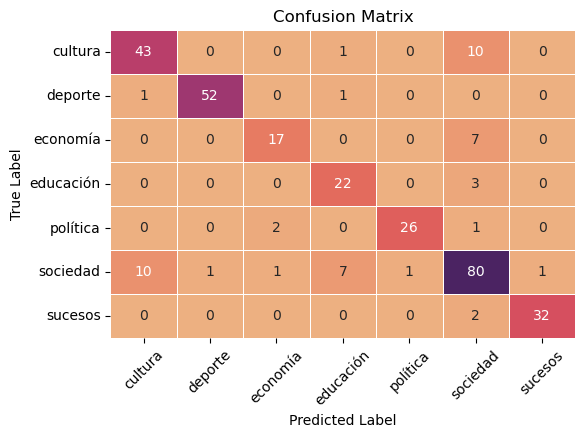

In [74]:
plot_conf_matrix(conf_matrix_lasolana)

####  fasttest

In [75]:
def get_embedding(word):
    try:
        embedding=loc_pretrained[word]
    except:
        embedding=np.zeros((150,))
    return embedding

In [76]:
X_train_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_train]
X_test_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_test]

In [77]:
predictions_pretrained, acc_pretrained = get_acc_RandomForestClassifier(X_train_embeddings, y_train, X_test_embeddings, y_test)

In [78]:
conf_matrix_pretrained = confusion_matrix(y_test, predictions_pretrained)
print(f'accuracy_pretrained: {acc_pretrained}')
print()
print(metrics.classification_report(y_test, predictions_pretrained, 
                                    target_names=['cultura','deporte','economía','educación','política','sociedad', 'sucesos']))

accuracy_pretrained: 0.8068535825545171

              precision    recall  f1-score   support

     cultura       0.73      0.76      0.75        54
     deporte       1.00      0.93      0.96        54
    economía       0.80      0.67      0.73        24
   educación       0.69      0.88      0.77        25
    política       0.96      0.93      0.95        29
    sociedad       0.78      0.72      0.75       101
     sucesos       0.71      0.88      0.79        34

    accuracy                           0.81       321
   macro avg       0.81      0.82      0.81       321
weighted avg       0.81      0.81      0.81       321



The `fasttext` highest accuracy was in classifying 'deporte', while 'economía' proved to be the most challenging, followed by 'sociedad' and 'cultura', as in `lasolana`. The confusion matrix below shows that 6 instances were incorrectly labeled as 'sociedad', again similarly as in `lasolana`.

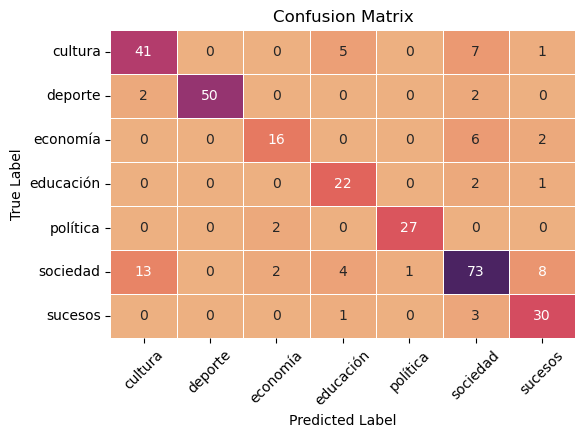

In [79]:
plot_conf_matrix(conf_matrix_pretrained)

#### lasolana+fasttest

In [80]:
def get_embedding(word):
    try:
        embedding=loc_finetuned[word]
    except:
        embedding=np.zeros((150,))
    return embedding

In [81]:
X_train_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_train]
X_test_embeddings=[np.mean(np.array(list(map(get_embedding,tok_sent))),axis=0) for tok_sent in X_test]

In [82]:
predictions_finetuned, acc_finetuned = get_acc_RandomForestClassifier(X_train_embeddings, y_train, X_test_embeddings, y_test)

In [83]:
conf_matrix_finetuned = confusion_matrix(y_test, predictions_finetuned)
print(f'accuracy_finetuned: {acc_finetuned}')
print()
print(metrics.classification_report(y_test, predictions_finetuned, 
                                    target_names=['cultura','deporte','economía','educación','política','sociedad', 'sucesos']))


accuracy_finetuned: 0.8566978193146417

              precision    recall  f1-score   support

     cultura       0.81      0.81      0.81        54
     deporte       1.00      0.94      0.97        54
    economía       0.76      0.79      0.78        24
   educación       0.79      0.88      0.83        25
    política       0.96      0.93      0.95        29
    sociedad       0.80      0.78      0.79       101
     sucesos       0.92      0.97      0.94        34

    accuracy                           0.86       321
   macro avg       0.86      0.87      0.87       321
weighted avg       0.86      0.86      0.86       321



The results indicate that `lasolana+fasttext` (finetuned) embeddings classify 'deporte' the most accurately, while 'sociedad' poses the most difficulties, which differs from the results of `lasolana`and `fasttext`.  This was expected as 'sociedad' is an umbrella term for various subtopics. Overall, the model's performance is good.

We can examine the errors in the confusion matrix below:

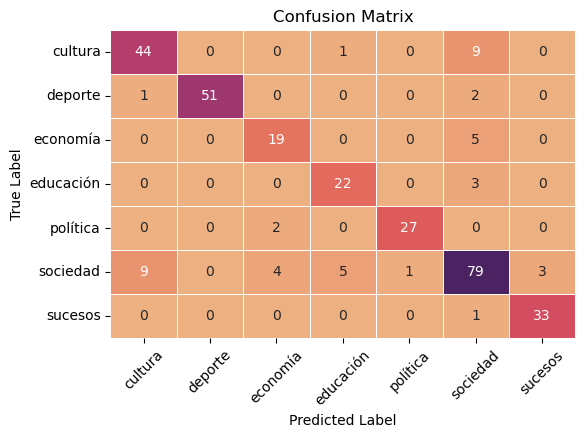

In [84]:
plot_conf_matrix(conf_matrix_finetuned)

Just one instance from the 'deporte' category was incorrectly classified as 'cultura' and two as 'sociedad', which may be seen as related category depending on the content of the article. Additionally, 9 incorrectly labeled instances that should belong to the 'sociedad' category are also labeled as 'cultura', indicating that 'cultura' may be a complex category that shares features with other categories.

### Final Results

The following experiments have yielded intriguing results, which we will analyze by type of evaluation:

* **Intrinsic evaluation**: While the 'toefl' results are impressive for all sets of embeddings, interesting outcomes are observed in the 'analogy; section. The average column (black borders) shows that both the `lasolana` and `fasttext` embeddings have the same accuracy, while the finetuned set performs worse. However, when looking at the 'solanero' and 'general' columns, their performance is inverse: in-domain embeddings (`lasolana`) perform well in the in-domain pair of analogies, while the general embeddings perform poorly. Otherwise, when testing on general pairs of analogies, the results are inverse. General embeddings (`fasttext`) perform well in general pairs, while in-domain embeddings perform poorly.

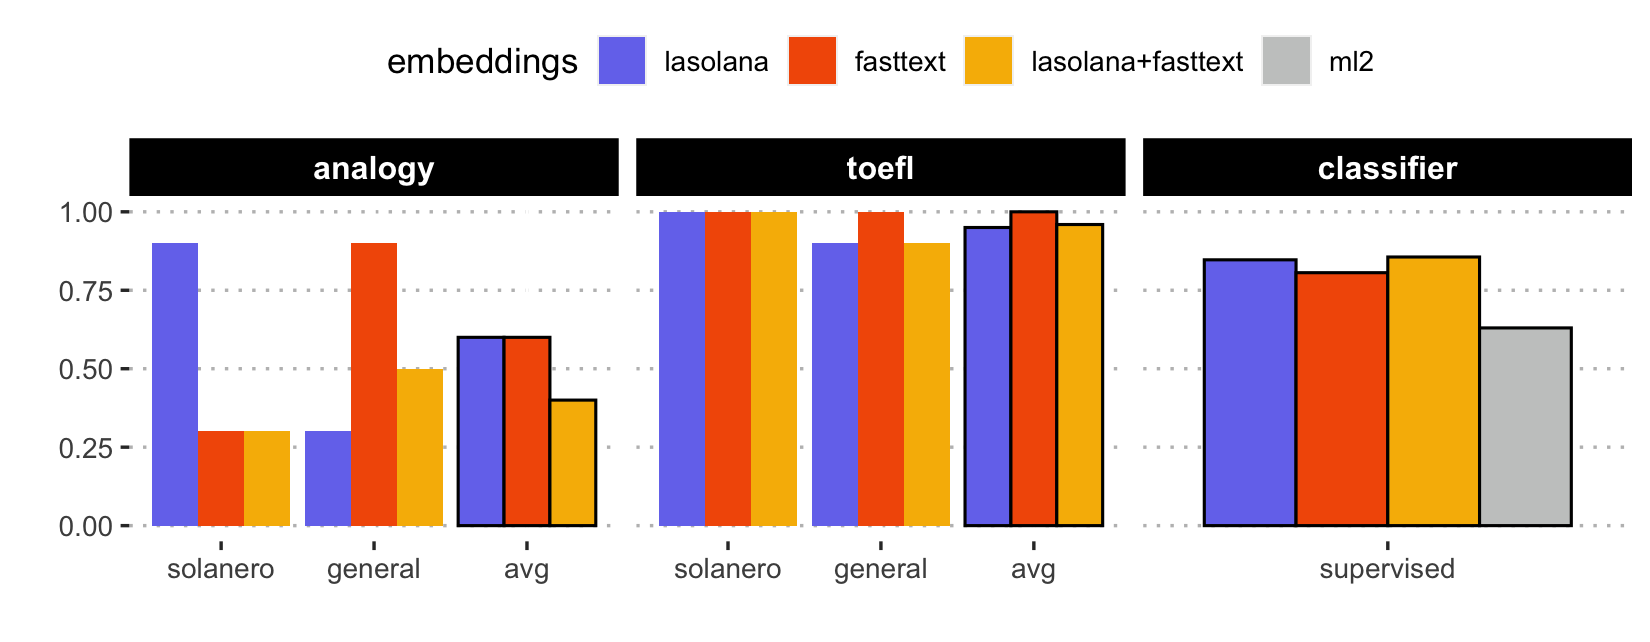

* **Extrinsic evaluation**: It is observed that approaches using word embeddings outperform the approach that uses a document-term matrix (grey column, accuracy of 0.63). However, the difference among word embedding sets is relatively small. The best set is the finetuned one with an accuracy of 0.85, while the in-domain embeddings are just one point below. The general set is the worst with an accuracy of 0.80. 

### Conclusion

This notebook provides an account of the entire training and evaluation process for three sets of embeddings: in-domain embeddings trained on collected data, Spanish fasttext embeddings, and a fine-tuned version of both. The results indicate that there is no superior set, as their application depends on the context. The extrinsic evaluation demonstrated that the fine-tuned embeddings should be used for downstream NLP tasks like text classification if the data to be classified has the same domain as ours. In-domain embeddings, such as `lasolana`, would be useful for dissemination purposes, such as presenting our project in the town of La Solana as a demonstration in an NLP workshop. Finally, `fasttext` embeddings are the best option for all general tasks.